# Data Processing

In [80]:
from statistics import median
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib as mpl
import seaborn as sb

feature_list_xlsx = ["CZA","CZH","CZV","TRF"]
feature_list_csv = ["EDU","MHI","perc_below_poverty", "perc_rental_housing","unemployment"]
feature_list = feature_list_csv + feature_list_xlsx
path = os.path.join(os.getcwd(),'data_clean')
feature_values = pd.read_excel(os.path.join(path,'TRF_2016.xlsx'))
geoid = feature_values['GEOID']
dataframes = {}

# Read in feature values
for year in range(2016, 2020):
    df_dict = {}
    df_dict['GEOID'] = geoid
    df_dict['YEAR'] = year
    for feature in feature_list_xlsx:
        file_name = feature + "_" + str(year) + '.xlsx'
        feature_values = pd.read_excel(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-5]]
    for feature in feature_list_csv:
        file_name = feature + "_" + str(year) + '.csv'
        feature_values = pd.read_csv(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-4]]
    dataframes[year] = pd.DataFrame(df_dict)

feature_values = pd.concat(dataframes.values(), ignore_index=True)
feature_values = feature_values.apply(pd.to_numeric, errors='coerce')

# # Replace missing feature values with column averages (median) # CHECK IF WE SHOULD MOVE THIS TO AFTER THE SPLIT
# for feature in feature_list:
#     col_ave = feature_values[feature].median()
#     feature_values[feature].fillna(value = col_ave, inplace = True)

# Read in house values
house_values = pd.read_csv(os.path.join(path,'home_value.csv'))
renamed_geoid = []
for row in house_values['GEOID']:
    tract_num = (row.split(',')[0]).replace("Census Tract ",'')
    if ('.' in tract_num):
        tract_num = '17031' + tract_num.replace('.','')
    else:
        tract_num = '17031' + tract_num + '00'
    renamed_geoid.append(int(tract_num))
house_values['GEOID'] = renamed_geoid

# Create dataframe of feature and outcome values
df = pd.merge(house_values, feature_values, on=['YEAR','GEOID'])
col_dict = {'CZA': 'violent_crime', 'CZH': 'aggravated_assault', 'CZV': 'homicide', 
            'MHI': 'household_income', 'TRF': 'traffic_intensity', 'EDU': 'college_rate',
            "perc_below_poverty": 'poverty_rate', "perc_rental_housing": 'rental_rate',"unemployment": 'unemploy_rate'}

df = df.rename(columns = col_dict)
print(df)

            GEOID  YEAR  house_value  violent_crime  aggravated_assault  \
0     17031100100  2016       267200            5.0                 0.0   
1     17031100200  2016       280300            5.0                 0.0   
2     17031100300  2016       339600            6.0                 0.0   
3     17031100400  2016       327700            0.0                 0.0   
4     17031100500  2016       317200            1.0                 0.0   
...           ...   ...          ...            ...                 ...   
2552  17031843500  2019       178700           18.0                 0.0   
2553  17031843600  2019       266500            4.0                 1.0   
2554  17031843700  2019       499700            9.0                 0.0   
2555  17031843800  2019       171900           47.0                 0.0   
2556  17031843900  2019       105700            9.0                 0.0   

      homicide  traffic_intensity  college_rate  household_income  \
0         10.0         605.408

# Summary Statistics

In [81]:
# feature_list = ["CZV", "TRF"] # remove this later
# outcome_feature_list = ['house_value'] + feature_list
# df = df.loc[:,outcome_feature_list]

df = df.drop('GEOID',1)
# df['YEAR'], _ = pd.factorize(df['YEAR'], sort=True)
print(df.head())
print(df.describe())
print(df.dtypes)

   YEAR  house_value  violent_crime  aggravated_assault  homicide  \
0  2016       267200            5.0                 0.0      10.0   
1  2016       280300            5.0                 0.0       9.0   
2  2016       339600            6.0                 0.0       6.0   
3  2016       327700            0.0                 0.0       0.0   
4  2016       317200            1.0                 0.0       4.0   

   traffic_intensity  college_rate  household_income  poverty_rate  \
0         605.408171          29.3           63058.0           9.5   
1         152.776736          34.8           68779.0           5.5   
2        1223.176635          26.8           66343.0           8.5   
3        1865.990705          17.9           87206.0           4.4   
4        1962.186822          27.5           93359.0           3.8   

   rental_rate  unemploy_rate  
0     0.329078           10.6  
1     0.293510            5.1  
2     0.316569            5.0  
3     0.040783            6.0  
4   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [82]:
print(df.dtypes)

YEAR                    int64
house_value             int64
violent_crime         float64
aggravated_assault    float64
homicide              float64
traffic_intensity     float64
college_rate          float64
household_income      float64
poverty_rate          float64
rental_rate           float64
unemploy_rate         float64
dtype: object


The dataframe comprises 2557 observations, where each observation contains the median house value (outcome variable) and 9 feature variables for a given census tract and year. The variables will be split 80:20, so that 80% of the data is in the training dataset and 20% is in the testing dataset.

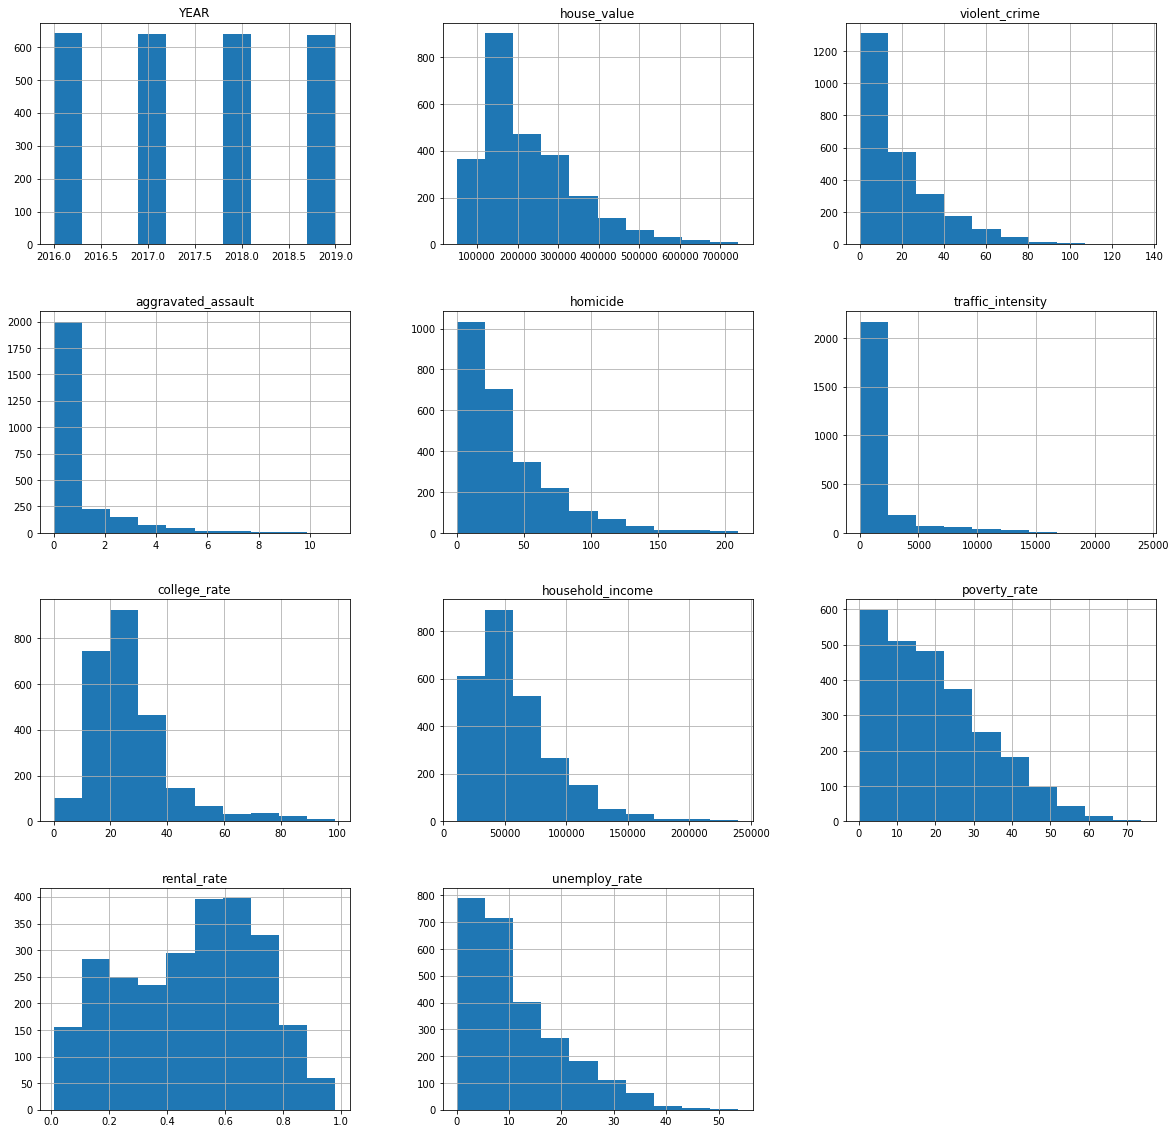

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(figsize=(20,20))
plt.show()

From plotting the distribution of the feature values, we observe that features vary significantly in scale, so we will be normalizing the feature parameters. We can also observe that features such as assault and traffic instensity are significantly skewed with most values being in the lowest value bucket, as such, we have concerns that there may no be enough variation in those features to be valuable for the model. We fortunately do not observe any outliers that would need to be excluded.

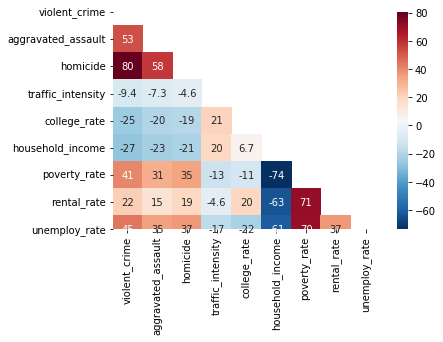

In [84]:
corr_matrix = df.corr()
corr_matrix["house_value"].sort_values(ascending=False)
mask = np.zeros_like(df.iloc[:,2:].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(df.iloc[:,2:].corr()*100, cmap='RdBu_r', annot = True, mask=mask)

Based on the heat map of the correlations of features, we can see that there is a positive correlation between housing price and median household income for an area, as well as the percent of the population enrolled in college. We can also observe a strong negative correlation between household price and unemployment levels and crime levels in the area. There is strong correlation between the crime features, which my make it worth combining them into a single feature.

# Feature Engineering

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop('house_value', 1)
y = df['house_value']

imputer = SimpleImputer(strategy="median")

# Replace NA feature values with feature median
for feature in feature_list:
    col_ave = X[feature].median()
    X[feature].fillna(value = col_ave, inplace = True)

# Convert categorical variables to factors
X['YEAR'], _ = pd.factorize(df['YEAR'], sort=True)

# Scale all features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_trans = (num_pipeline.fit_transform(X))

train_x, test_x, train_y, test_y = train_test_split(X_trans, y.to_numpy(), test_size=0.2, random_state=123)

# Appending biases
# train_x = np.concatenate((np.ones((train_x.shape[0], 1)), train_x), axis=1)
# test_x = np.concatenate((np.ones((test_x.shape[0], 1)), test_x), axis=1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


KeyError: 'EDU'

# Model Training

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error  

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
lin_predictions = lin_reg.predict(train_x) 
lin_mse = mean_squared_error(train_y, lin_predictions)  
lin_rmse = np.sqrt(lin_mse) 
print(lin_rmse)

# Cross validation
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

80176.6020143403
Scores: [73279.52625988 76702.12730417 78584.52591617 81474.40066212
 74500.24004721 76491.00422763 83362.70778147 96397.44004634
 88688.1434582  76946.89578336]
Mean: 80642.70114865644
Standard deviation: 6809.089842356591


### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=123)
tree_reg.fit(train_x, train_y)
dt_predictions = tree_reg.predict(train_x)
scores = cross_val_score(tree_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [86391.08524469 73529.68937451 78407.93638277 73701.20791941
 73825.74308101 84501.01374261 85961.84487614 77454.52302645
 86841.15824139 86921.44949524]
Mean: 80753.56513842328
Standard deviation: 5606.721537710948


### Support Vector Machine

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_x, train_y)
svm_predictions = svm_reg.predict(train_x)
svm_mse = mean_squared_error(train_y, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

119595.60017030929

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_x, train_y)
rf_predictions = forest_reg.predict(train_x) 
forest_mse = mean_squared_error(train_y, rf_predictions) 
forest_rmse = np.sqrt(forest_mse) 
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

22357.94096084883
Scores: [59799.9617151  51052.34768764 59770.45497058 61654.4734251
 52953.2710217  67696.22550427 58282.22711122 69001.99909704
 65397.51037415 61838.88069993]
Mean: 60744.73516067267
Standard deviation: 5502.124808399647


# Fine Tuning Model Using Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

feature_importances = grid_search.best_estimator_.feature_importances_
print(sorted(zip(feature_importances, ['YEAR'] + feature_list_xlsx + feature_list_csv), reverse=True))


{'max_features': 8, 'n_estimators': 30}
75979.1485000433 {'max_features': 2, 'n_estimators': 3}
67077.96799885746 {'max_features': 2, 'n_estimators': 10}
64583.43267139611 {'max_features': 2, 'n_estimators': 30}
74069.05070411418 {'max_features': 4, 'n_estimators': 3}
65088.79440626945 {'max_features': 4, 'n_estimators': 10}
62149.37650431445 {'max_features': 4, 'n_estimators': 30}
74641.72686437785 {'max_features': 6, 'n_estimators': 3}
64733.94475482537 {'max_features': 6, 'n_estimators': 10}
62228.7532829323 {'max_features': 6, 'n_estimators': 30}
75491.66463952285 {'max_features': 8, 'n_estimators': 3}
65367.10611917961 {'max_features': 8, 'n_estimators': 10}
61756.39748823879 {'max_features': 8, 'n_estimators': 30}
74572.06701956684 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
65044.5915369999 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
71932.79548688485 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
62757.83606553338 {'bootstrap': False, 